In [149]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SIR_hierarchical, SEIR_hierarchical, plot_samples, plot_forecast, plot_R0
import util

# Dev: Hierarchical Model

growth rate [-0.03398098 -0.06478296 -0.03826216 -0.12591206 -0.0141241  -0.05994564
 -0.06042299 -0.08620627 -0.04123732  0.0581409 ]


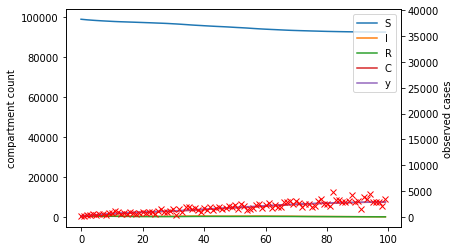

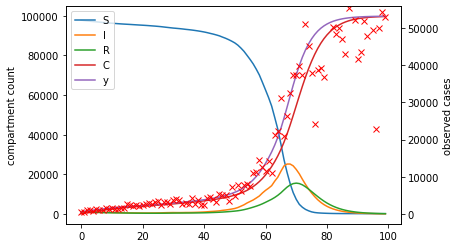

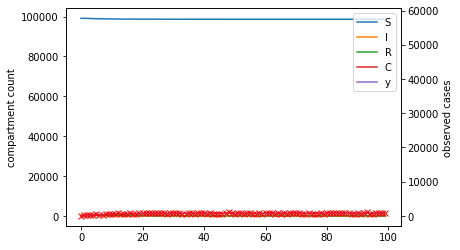

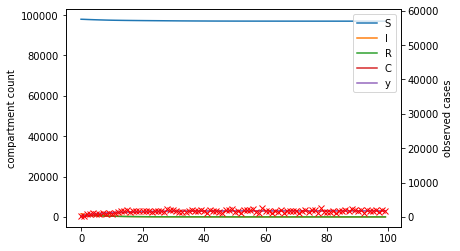

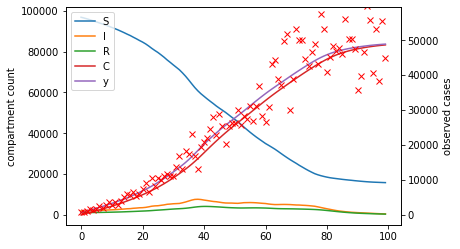

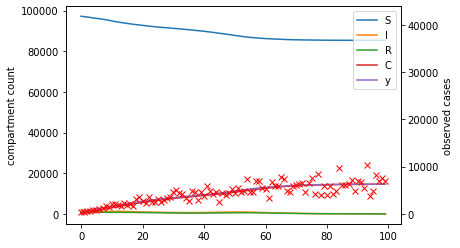

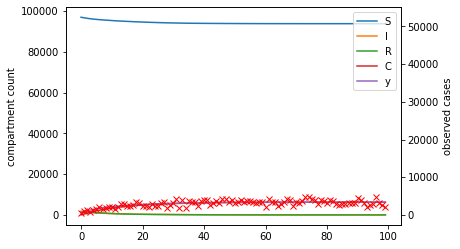

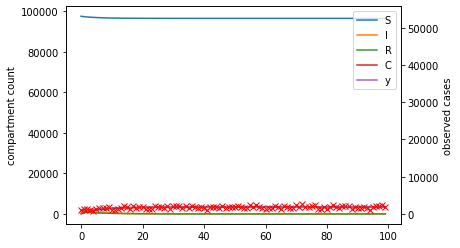

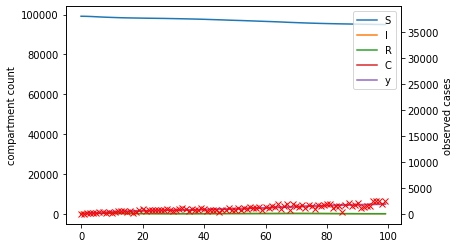

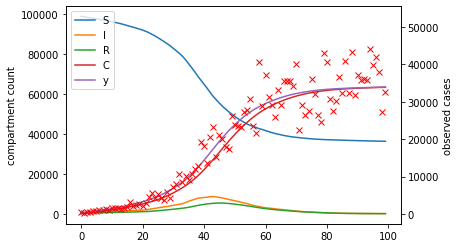

In [113]:
i = 1
num_places = 10
T = 50
T_future = 50
log_scale=False

def gen_covariates(places=None, num_places=5, intercept=False, drop_first=True):
    if places is None:
        places = [f'{i}' for i in range(num_places)]
    places = pd.DataFrame({'place': places})
    covariates = pd.get_dummies(places, drop_first=drop_first)
    if intercept:
        covariates['intercept'] = 1
    return covariates

with numpyro.handlers.seed(rng_seed=i):
    
    beta, xx, yy, oo = SEIR_hierarchical(num_places=num_places,
                                         T=T,
                                         T_future=T_future,
                                         place_covariates=gen_covariates(num_places=num_places))

for x, y, obs_rate in zip(xx, yy, oo):

    T = x.shape[0]
    ts = np.arange(T)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    l1 = ax1.plot(ts, x)
    l2 = ax2.plot(ts, y, 'x', color='r')

    plt.legend(l1 + l2, ['S', 'I', 'R', 'C', 'y'])

    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')

    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )

    plt.show()

In [ ]:
#def test_prior_predictive():
T = 100
T_future = 100

num_places = 5

N = 10**np.arange(5)
predictive = Predictive(SIR_hierarchical, 
                        posterior_samples = {}, 
                        num_samples=1000)

samples = predictive(PRNGKey(2), 
                     num_places = num_places,
                     T = T, 
                     T_future=100,
                     N = N)

In [ ]:
from models import plot_samples

for i in range(num_places):

    shared_params = ['gamma_', 'beta_', 'det_rate_']
    place_samples = {k: v[:,i,...] for k, v in samples.items() if not k in shared_params}
    plot_samples(place_samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
# for i in range(2):
#     test_prior(i, num_places=3, T=50, T_future=50, N=1e8)
#test_prior_predictive()

# Run Inference

In [142]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

places = list(state_data.keys())
#places = ['NY', 'WA', 'MA', 'OH', 'AL', 'WV', 'ME', 'AK']
#places = ['NY', 'WA']

num_places = len(places)

start = pd.Timestamp('2020-03-04')

place_data = {place: data[place]['data'].confirmed for place in places}
confirmed = pd.DataFrame(data = place_data)[start:]

T = len(confirmed)
N = np.array([data[place]['pop'] for place in places])

args = {
    'num_places': num_places,
    'N': N,
    'T': T,
    'rw_scale': 2e-1,
    'det_conc': 10,
    'place_covariates' : gen_covariates(places)
}

prob_model = SEIR_hierarchical

kernel = NUTS(prob_model,
              init_strategy = numpyro.infer.util.init_to_median())

mcmc = MCMC(kernel, 
            num_warmup=1000,
            num_samples=1000, 
            num_chains=1)

obs = confirmed.values.T

mcmc.run(jax.random.PRNGKey(1),
         obs = obs,
         **args)

mcmc.print_summary()
mcmc_samples = mcmc.get_samples()

# Prior samples for comparison
prior = Predictive(prob_model, posterior_samples = {}, num_samples = 1000)
prior_samples = prior(PRNGKey(2), **args)

# Posterior predictive samples for visualization
args['rw_scale'] = 0 # set drift to zero for forecasting
post_pred = Predictive(prob_model, posterior_samples = mcmc_samples)
post_pred_samples = post_pred(PRNGKey(2), T_future=100, **args)

growth rate [0.2993494  0.30885977 0.30671942 0.29664022 0.3114103  0.31861824
 0.3193218  0.29365546 0.3099674  0.30596504 0.32923824 0.3096087
 0.3120818  0.32521158 0.28174222 0.2843956  0.29640144 0.29752028
 0.3048654  0.31048727 0.3090592  0.29078868 0.31561825 0.30351576
 0.30579087 0.30153155 0.31104255 0.2963087  0.30439472 0.32838425
 0.2927287  0.30028003 0.3429237  0.29382452 0.29965013 0.30395627
 0.2922188  0.33299485 0.31152657 0.27768442 0.30646917 0.32855943
 0.315136   0.28300297 0.30535805 0.30095115 0.30749273 0.2894443
 0.32709908 0.30167043 0.29544884]
growth rate Traced<ConcreteArray([0.29934946 0.3088598  0.30671942 0.29664022 0.3114103  0.31861824
 0.3193218  0.29365546 0.3099674  0.3059651  0.32923818 0.3096087
 0.3120818  0.32521158 0.2817422  0.28439564 0.29640144 0.29752028
 0.30486533 0.31048727 0.3090592  0.29078868 0.31561825 0.30351582
 0.30579087 0.30153155 0.31104255 0.2963087  0.30439472 0.32838425
 0.29272866 0.30028003 0.34292367 0.29382452 0.29965

  0%|          | 0/2000 [00:00<?, ?it/s]

growth rate [0.2801169  0.29876506 0.2673307  0.3051563  0.23941952 0.32333356
 0.29426226 0.26533887 0.28151697 0.32436818 0.3016287  0.2528748
 0.24205616 0.24655056 0.22503805 0.24451983 0.34511364 0.26330316
 0.2584144  0.24662003 0.26998225 0.2611407  0.31915897 0.27942127
 0.24191779 0.31174716 0.2659213  0.35857087 0.25619823 0.26237705
 0.32122585 0.29181975 0.32943884 0.26788855 0.2550056  0.33938366
 0.31528854 0.31943882 0.3044364  0.23652908 0.27831396 0.33621317
 0.29200935 0.2912923  0.27524334 0.32299238 0.31310248 0.2945301
 0.28658035 0.21189912 0.34008288]
growth rate Traced<ShapedArray(float32[51])>with<JVPTrace(level=6/1)>
growth rate Traced<ShapedArray(float32[51])>with<JVPTrace(level=7/1)>
growth rate Traced<ShapedArray(float32[51])>with<JVPTrace(level=7/1)>
growth rate Traced<ShapedArray(float32[51])>with<JVPTrace(level=8/1)>


sample: 100%|██████████| 2000/2000 [1:09:10<00:00,  2.08s/it, 255 steps of size 2.62e-02. acc. prob=0.87]


growth rate Traced<ShapedArray(float32[51]):JaxprTrace(level=4/0)>

                          mean       std    median      5.0%     95.0%     n_eff     r_hat
               E0[0]      1.89      0.99      1.81      0.00      3.19    847.51      1.00
               E0[1]      0.76      0.70      0.56      0.00      1.71   1599.56      1.00
               E0[2]      2.44      1.16      2.36      0.54      4.34    867.51      1.00
               E0[3]      3.24      1.24      3.14      1.21      5.30    823.76      1.00
               E0[4]      4.03      2.70      3.76      0.12      7.70   1212.91      1.00
               E0[5]     39.90     14.45     38.52     16.26     62.02    809.83      1.00
               E0[6]      0.15      0.12      0.12      0.00      0.31   1339.28      1.00
               E0[7]      1.08      0.52      1.08      0.11      1.81   1259.21      1.00
               E0[8]      0.80      0.57      0.70      0.00      1.52   1071.14      1.00
               E0[9]  

          beta[35,9]      1.37      0.30      1.34      0.87      1.82   1426.06      1.00
         beta[35,10]      1.23      0.27      1.20      0.77      1.62   1156.59      1.00
         beta[35,11]      1.15      0.25      1.11      0.75      1.54    878.40      1.00
         beta[35,12]      1.10      0.23      1.09      0.73      1.46   1034.74      1.00
         beta[35,13]      1.08      0.23      1.06      0.74      1.47   1088.39      1.00
         beta[35,14]      1.07      0.23      1.05      0.68      1.41   1184.50      1.00
         beta[35,15]      1.07      0.23      1.04      0.71      1.47   1266.15      1.00
         beta[35,16]      1.08      0.24      1.06      0.69      1.46   1011.63      1.00
         beta[35,17]      1.08      0.26      1.05      0.68      1.47   1348.99      1.00
         beta[35,18]      1.06      0.24      1.03      0.67      1.45   1279.97      1.00
         beta[35,19]      1.06      0.25      1.02      0.66      1.44   1251.09      1.00

growth rate Traced<ShapedArray(float32[51]):JaxprTrace(level=4/0)>


In [66]:
from compartment import SEIRModel

gamma = mcmc_samples['gamma'].mean(axis=0)
beta0 = mcmc_samples['beta0'].mean(axis=0)
sigma = mcmc_samples['sigma'].mean(axis=0)

print("gamma", gamma)
print("beta", beta0)
print("sigma", sigma)
print("det_rate", mcmc_samples['det_rate'].mean(axis=0))

print("growth rate", SEIRModel.growth_rate((beta0, sigma, gamma)))

KeyError: 'gamma'

In [67]:
print(post_pred_samples)

{'beta_future': DeviceArray([[[0.56798303, 0.56798303, 0.56798303, ..., 0.56798303,
               0.56798303, 0.56798303],
              [0.5048385 , 0.5048385 , 0.5048385 , ..., 0.5048385 ,
               0.5048385 , 0.5048385 ]],

             [[0.56863034, 0.56863034, 0.56863034, ..., 0.56863034,
               0.56863034, 0.56863034],
              [0.5054174 , 0.5054174 , 0.5054174 , ..., 0.5054174 ,
               0.5054174 , 0.5054174 ]],

             [[0.56709266, 0.56709266, 0.56709266, ..., 0.56709266,
               0.56709266, 0.56709266],
              [0.5059172 , 0.5059172 , 0.5059172 , ..., 0.5059172 ,
               0.5059172 , 0.5059172 ]],

             ...,

             [[0.5779291 , 0.5779291 , 0.5779291 , ..., 0.5779291 ,
               0.5779291 , 0.5779291 ],
              [0.66993606, 0.66993606, 0.66993606, ..., 0.66993606,
               0.66993606, 0.66993606]],

             [[0.5722167 , 0.5722167 , 0.5722167 , ..., 0.5722167 ,
               0.5722167 

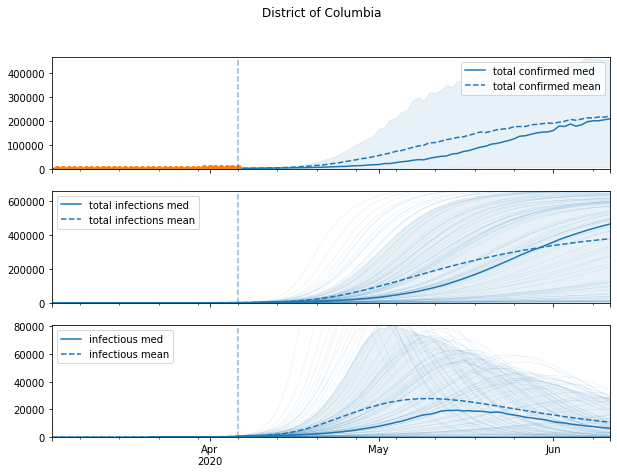

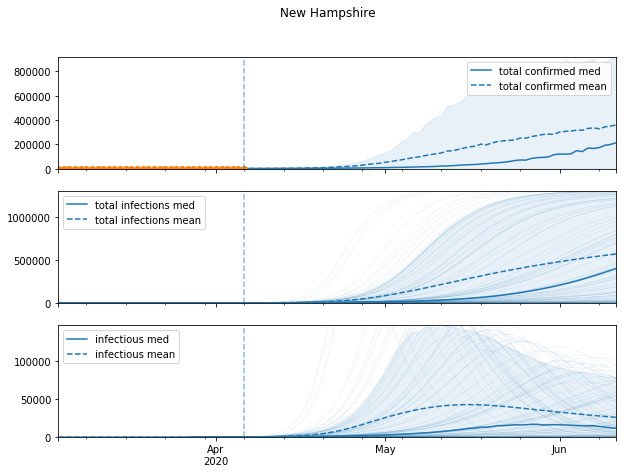

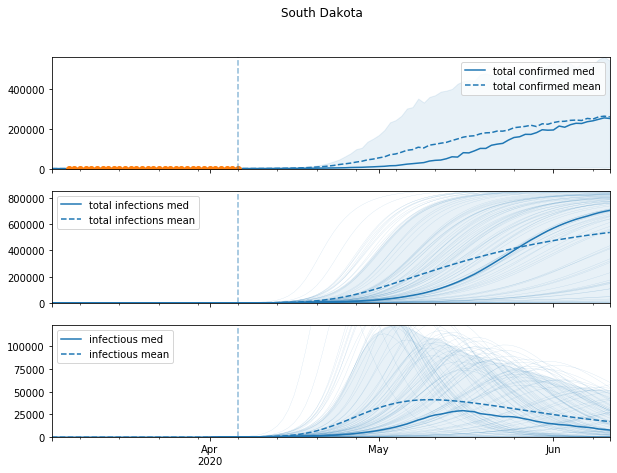

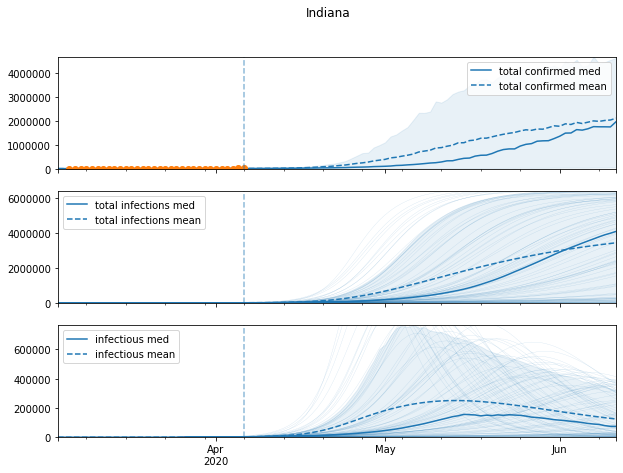

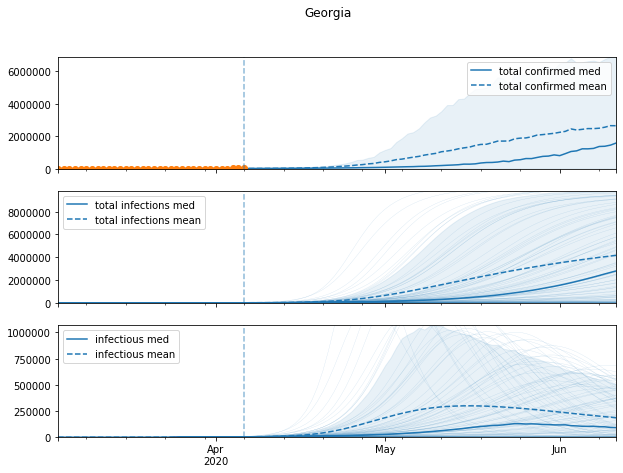

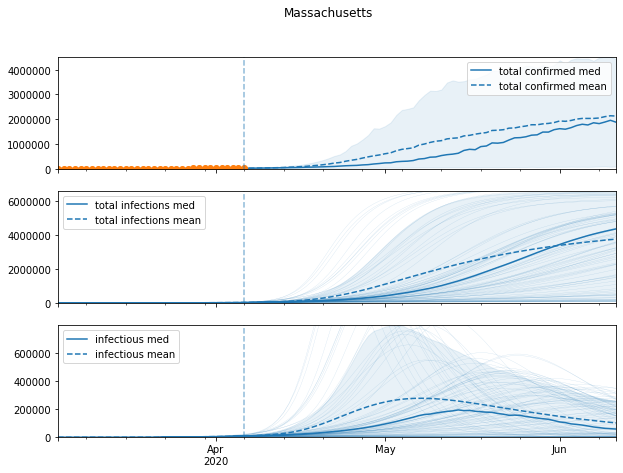

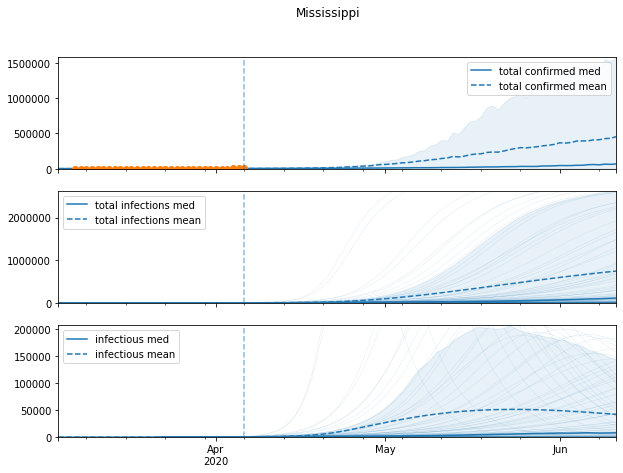

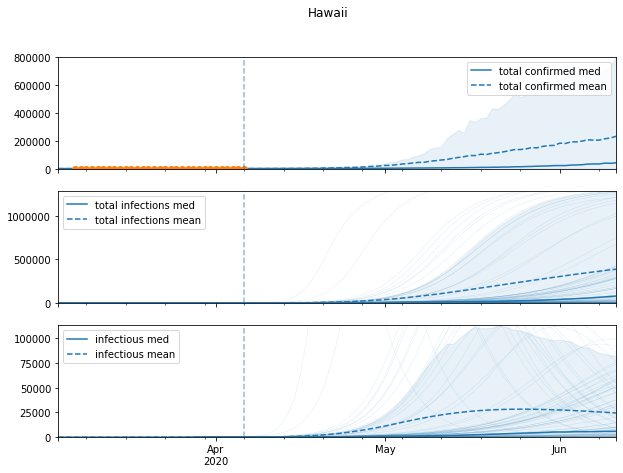

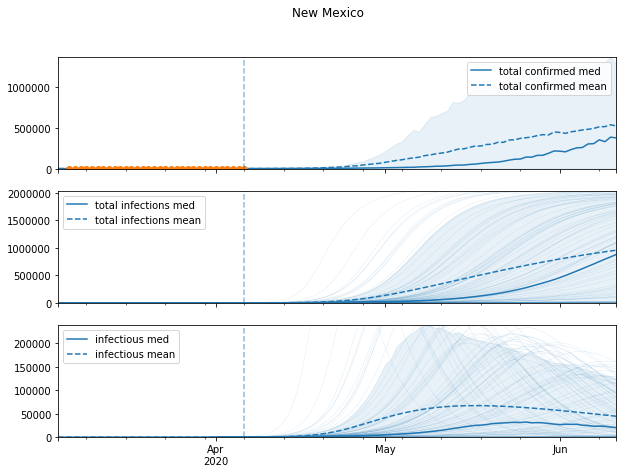

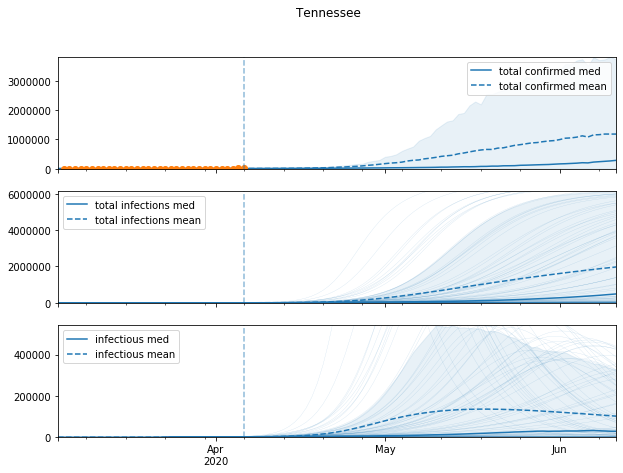

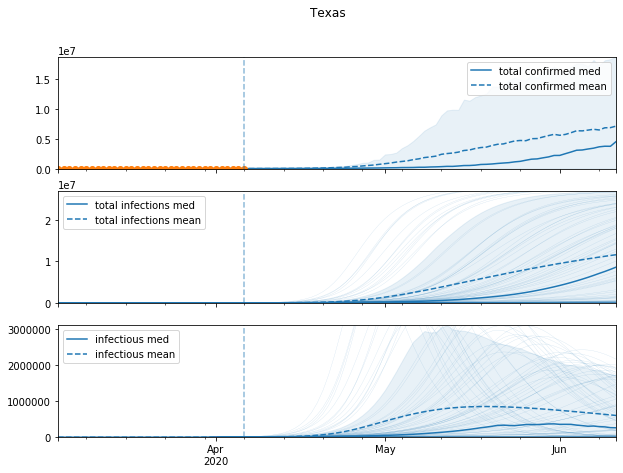

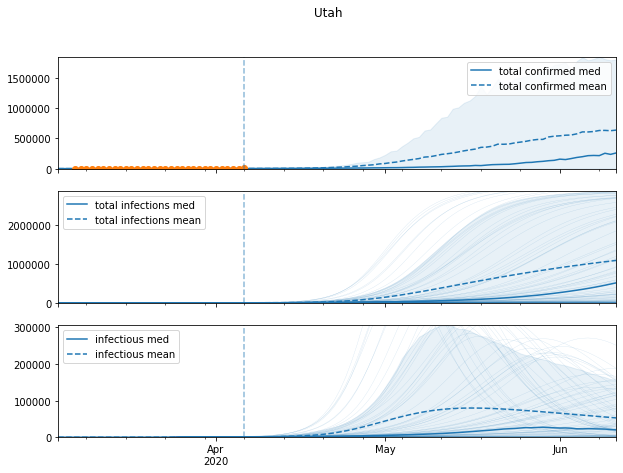

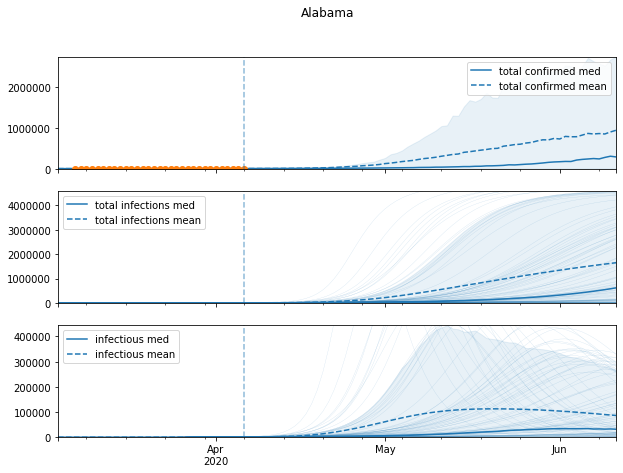

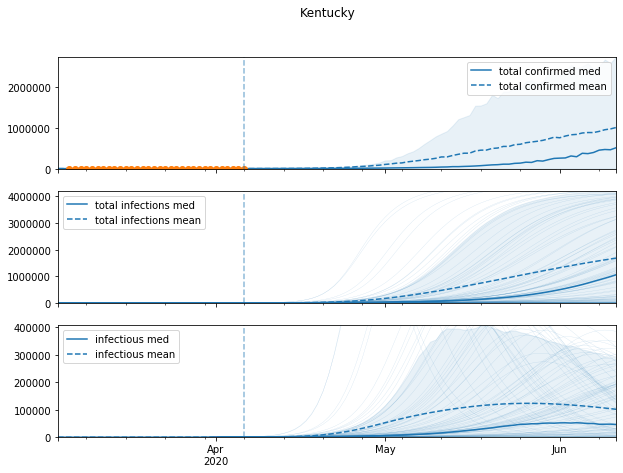

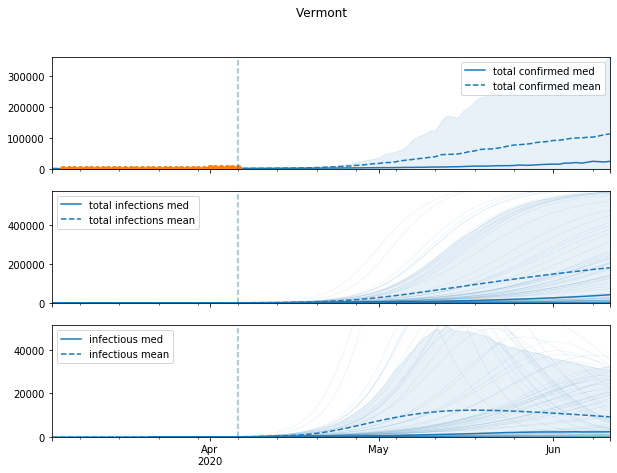

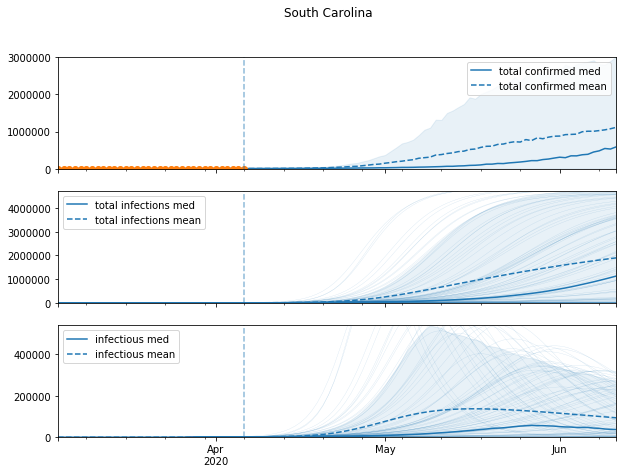

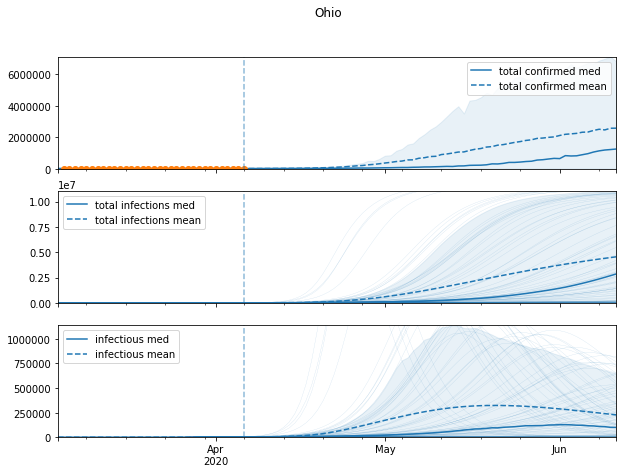

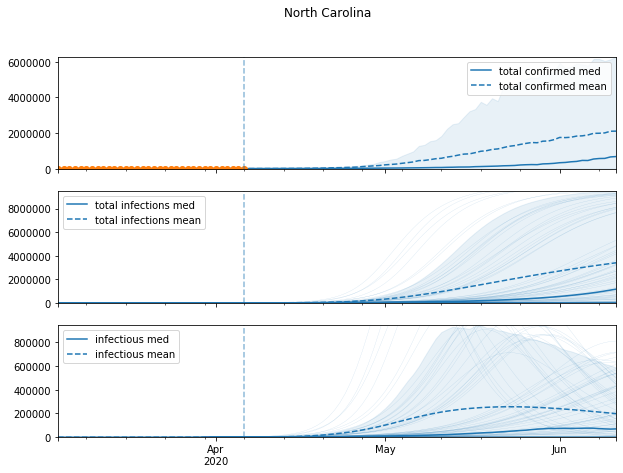

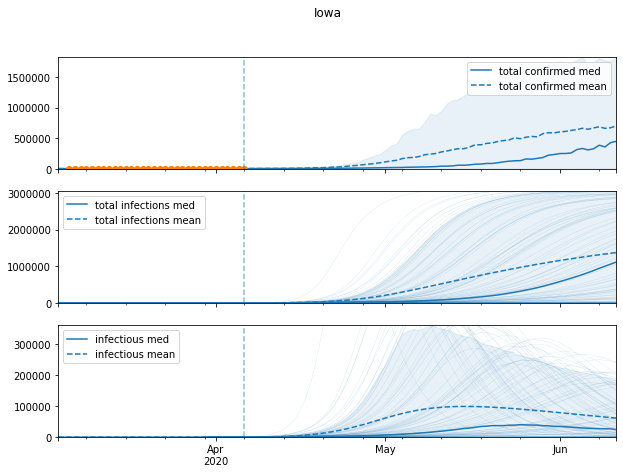

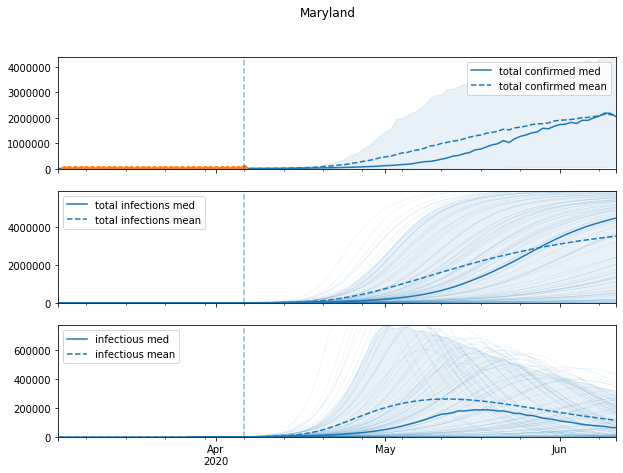

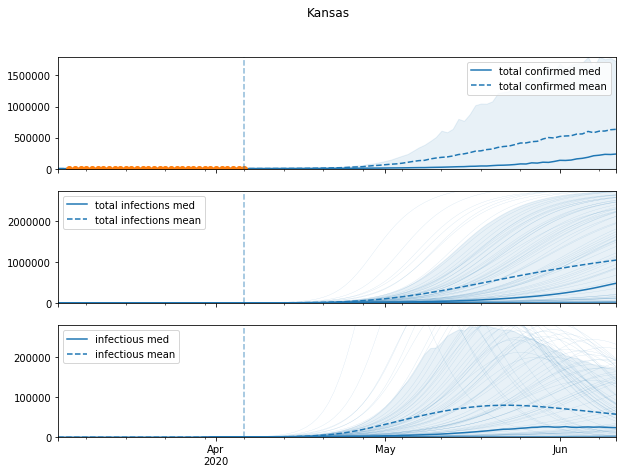

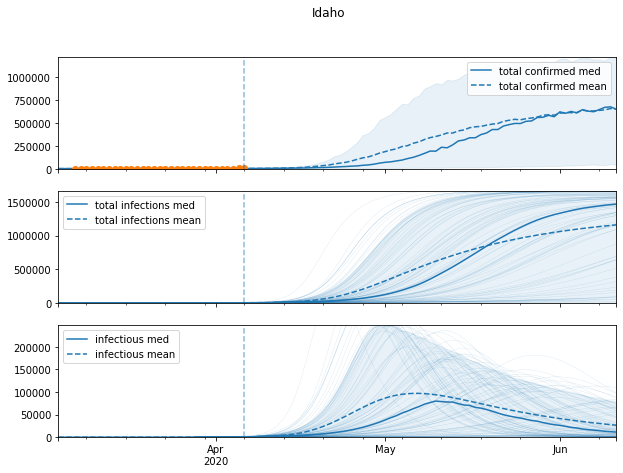

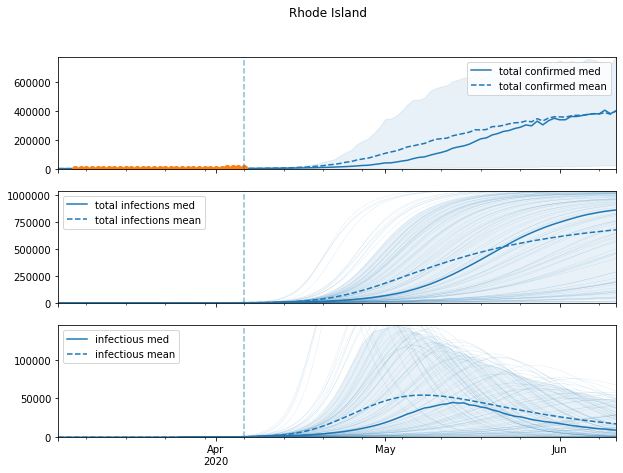

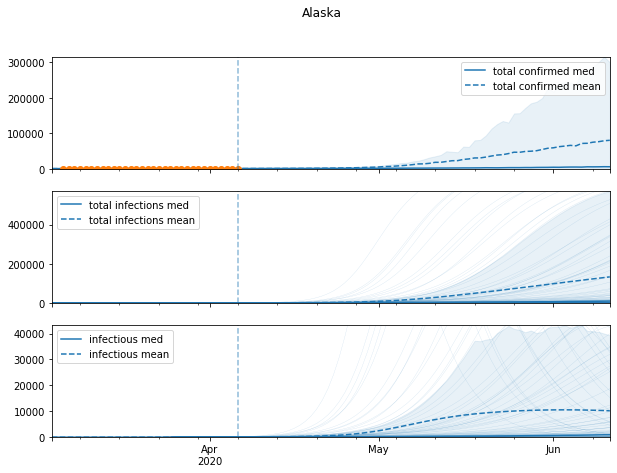

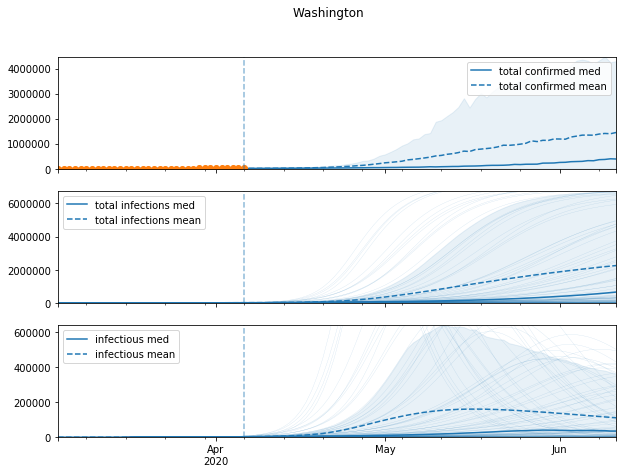

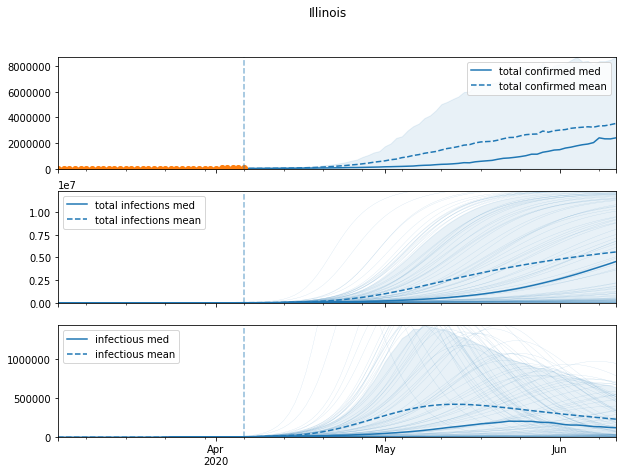

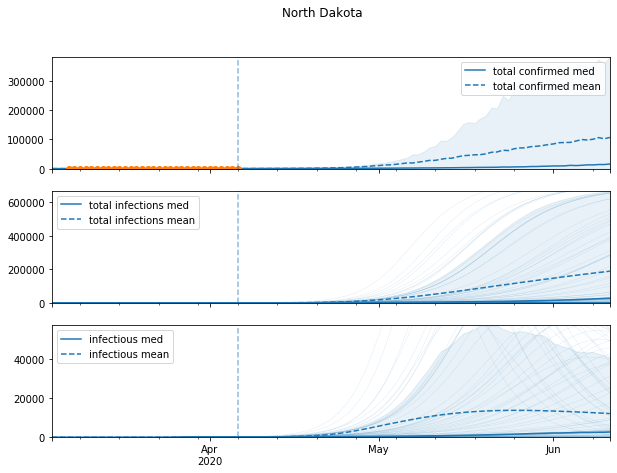

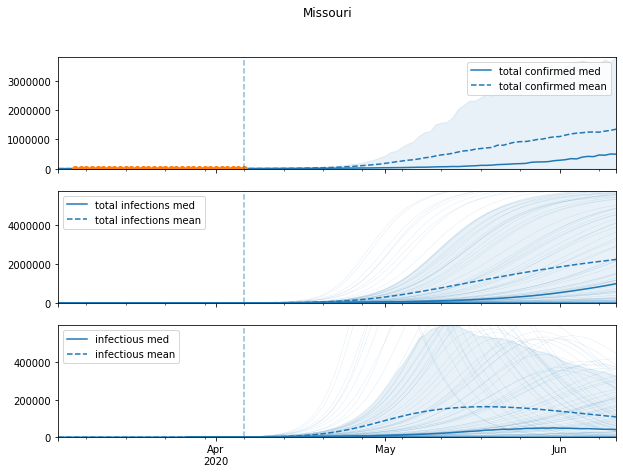

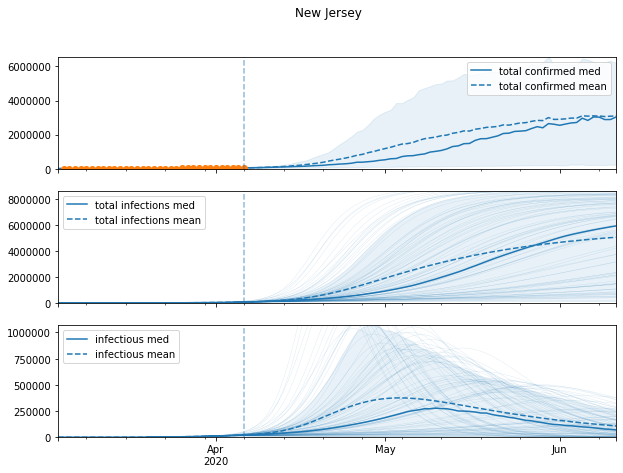

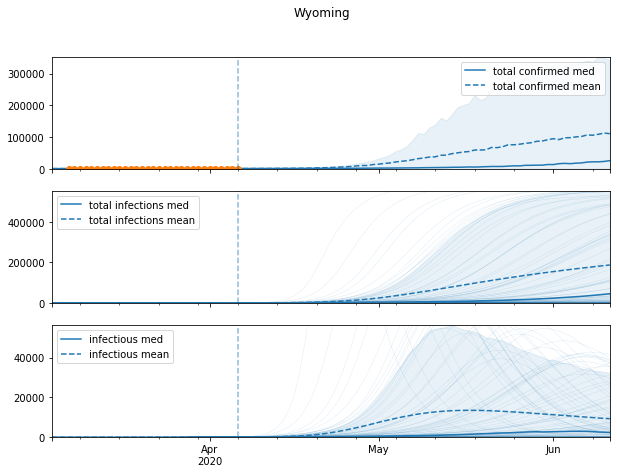

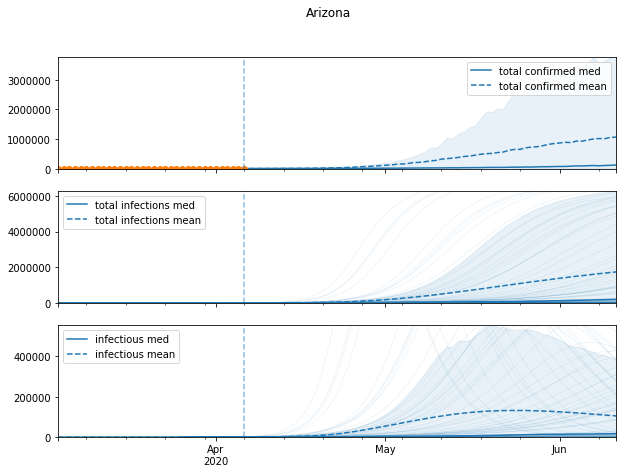

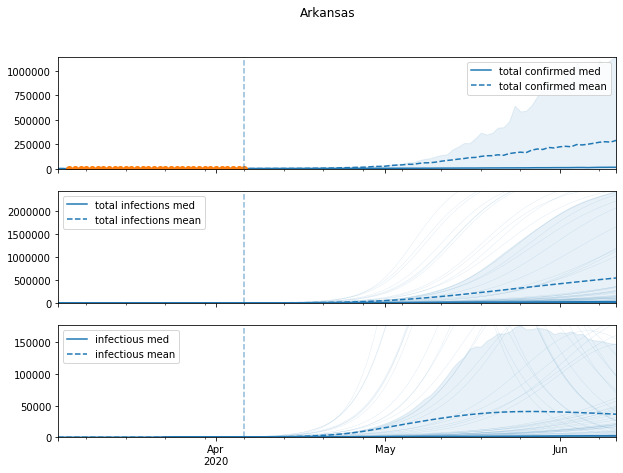

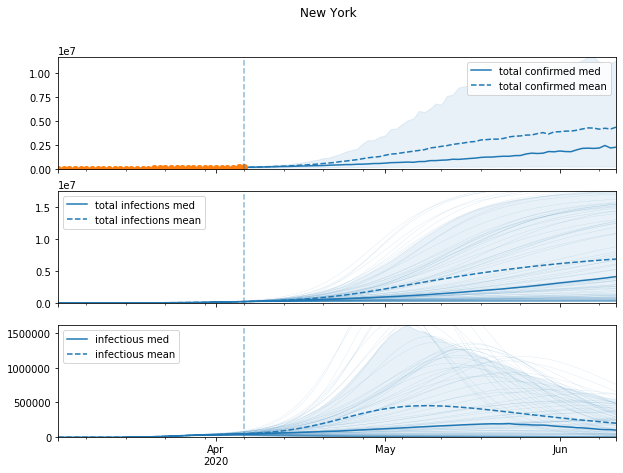

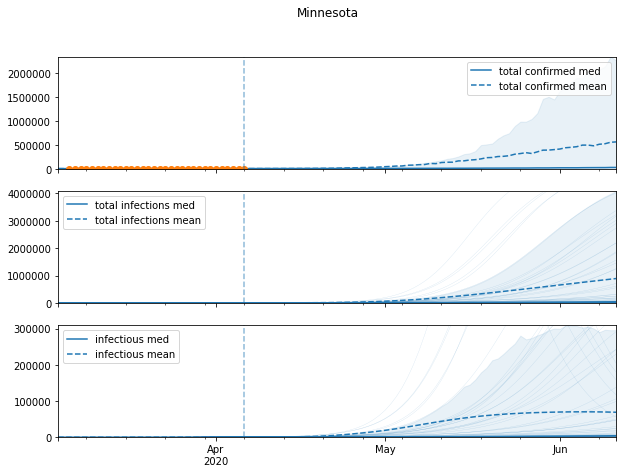

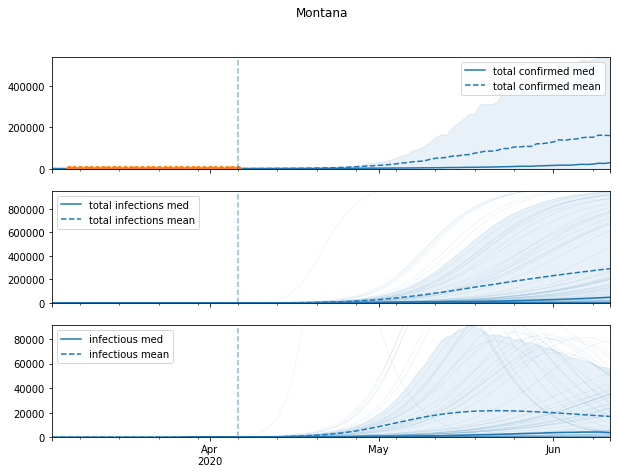

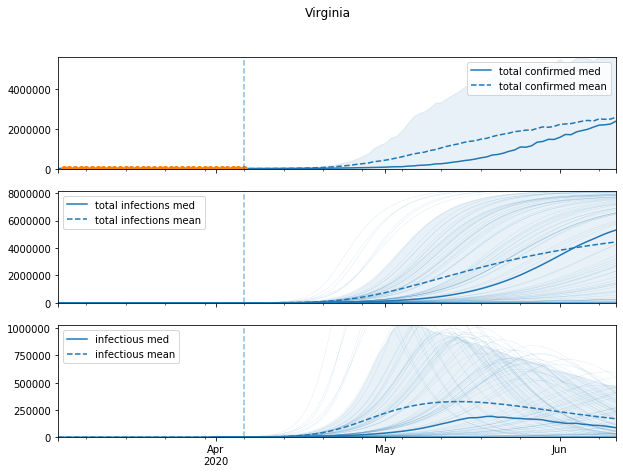

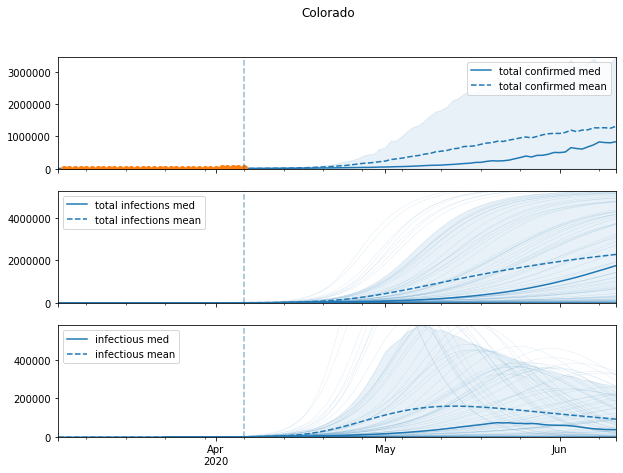

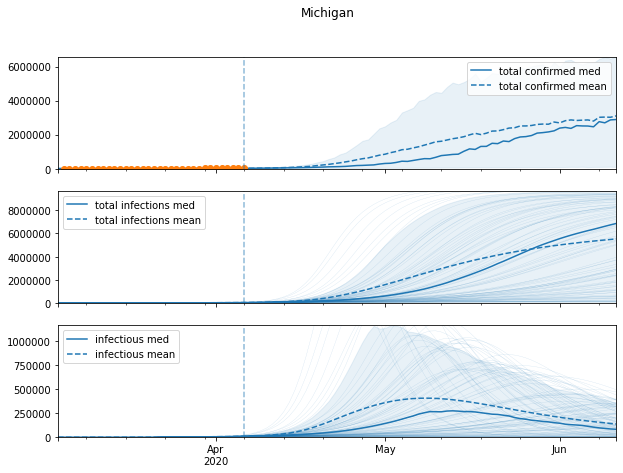

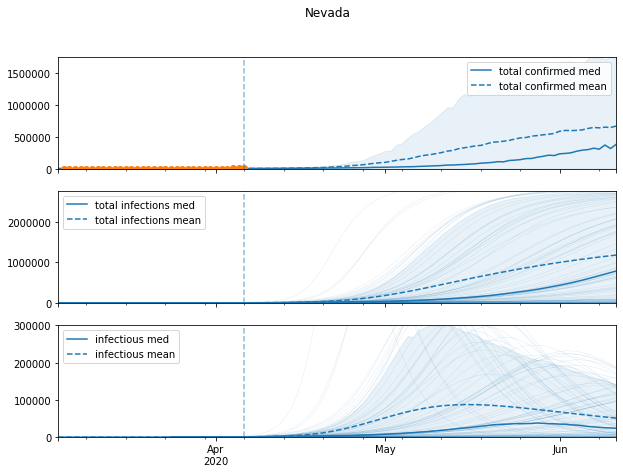

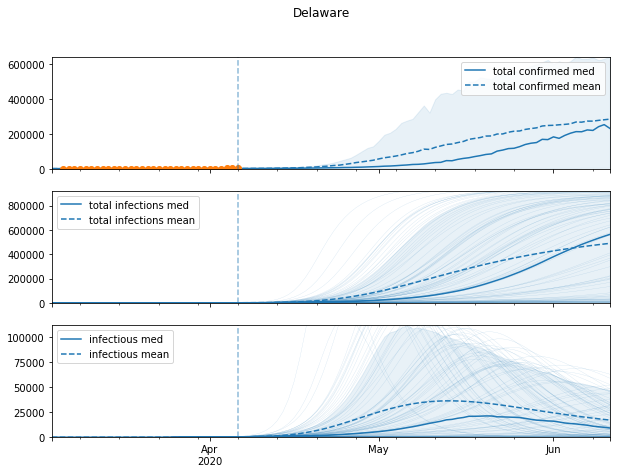

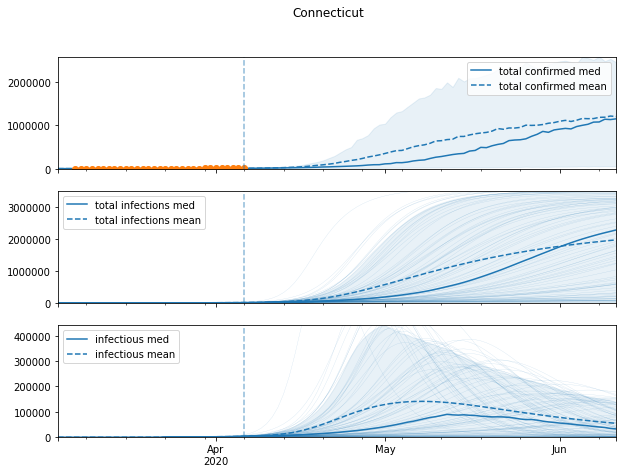

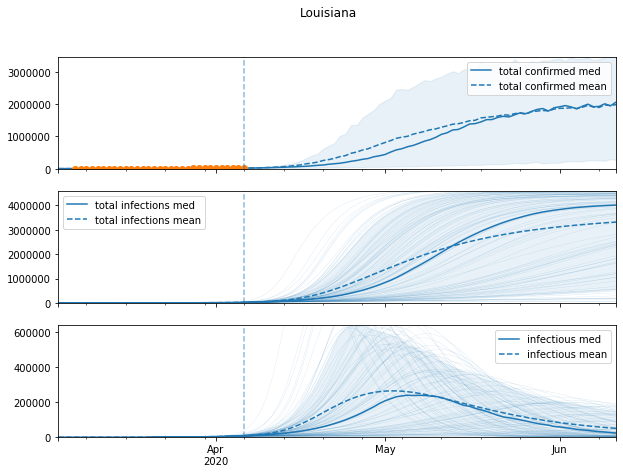

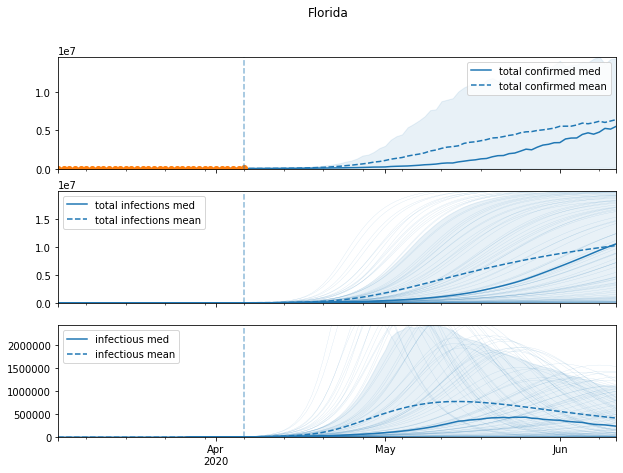

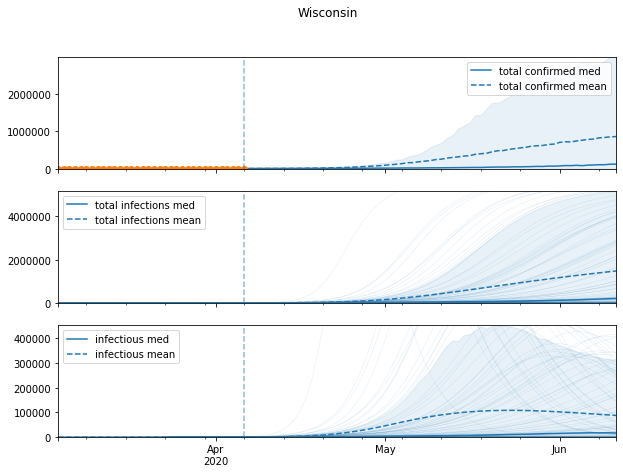

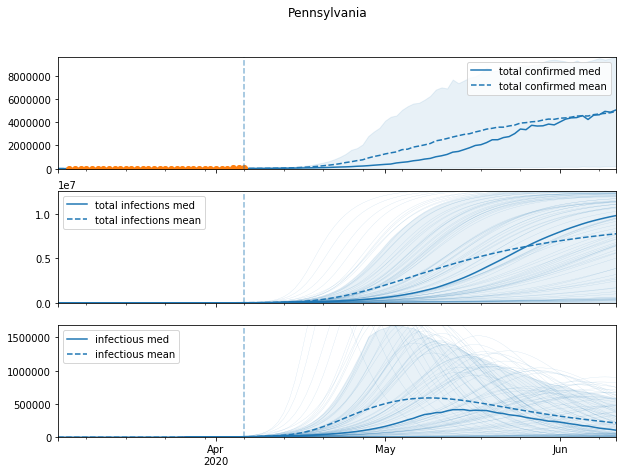

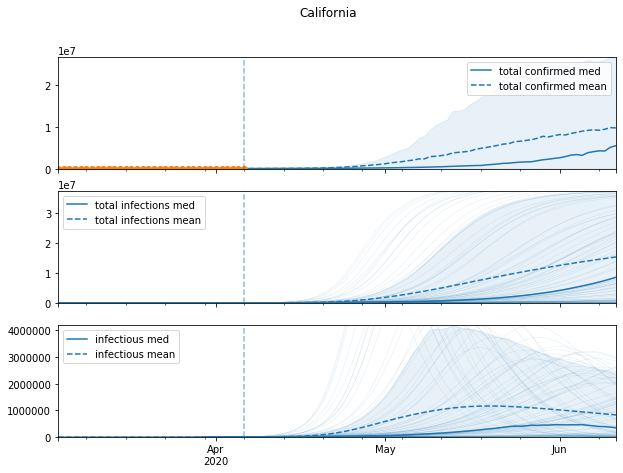

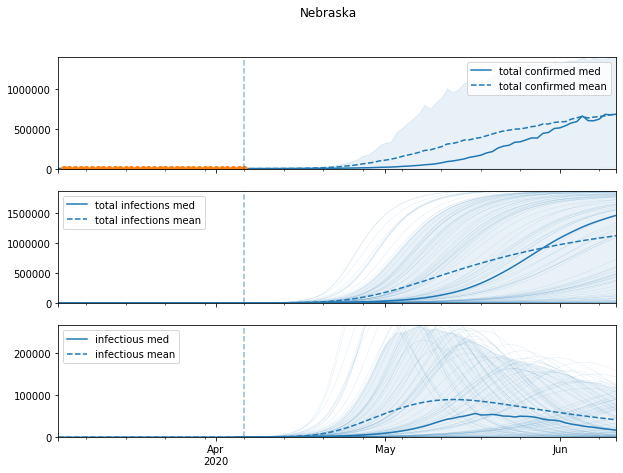

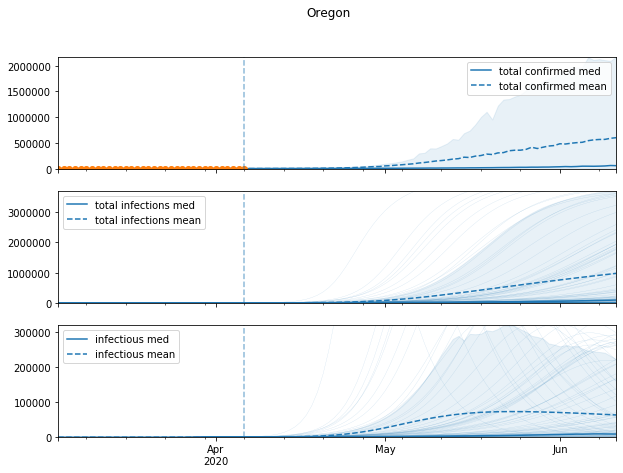

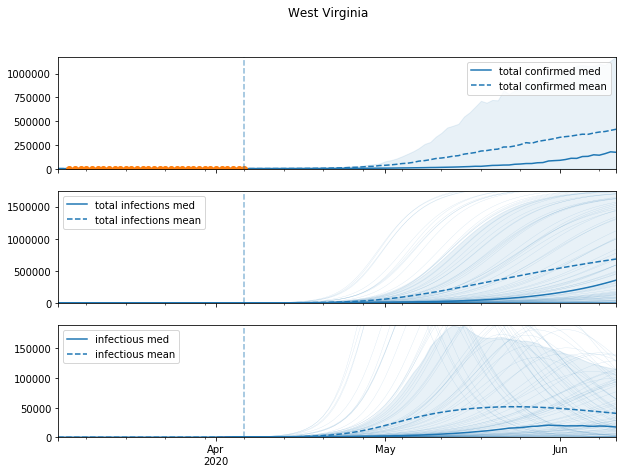

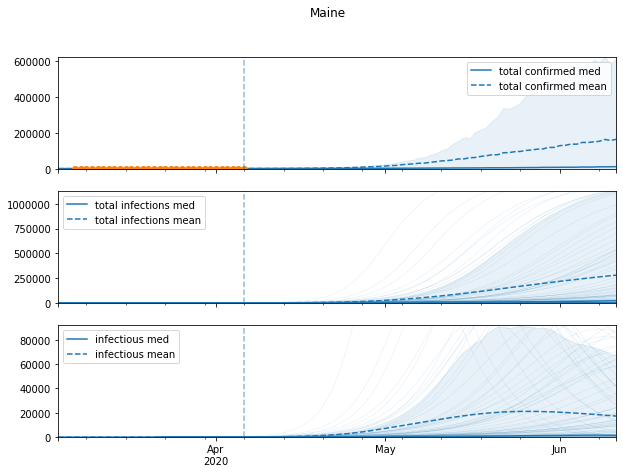

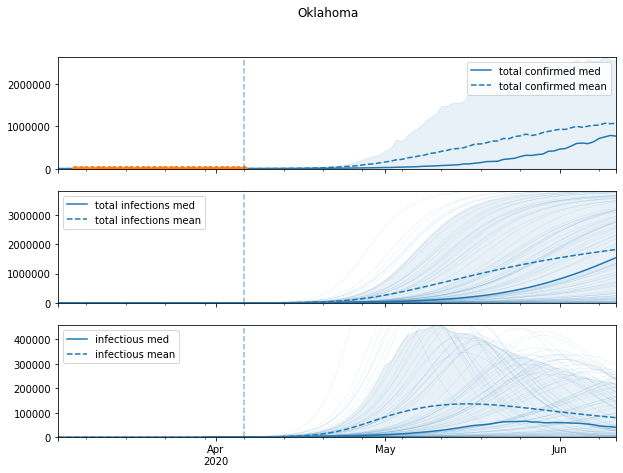

In [157]:
T = 100
for i, place in zip(range(num_places), places):
    
    t = pd.date_range(start=start, periods=T, freq='D')
    
    shared_params = ['beta0_base', 'gamma_base', 'sigma_base', 'det_rate_base']
    place_samples = {k: v[:,i,...] for k, v in post_pred_samples.items() if not k in shared_params}

    scale = 'lin'
    t = pd.date_range(start=start, periods=T, freq='D')
    fig, ax = plot_forecast(place_samples, T, confirmed[place], t=t, scale=scale)

    #plot_samples(place_samples, plot_fields=['I'], ax=ax, t=t, T=T)
    #plt.plot(obs[i,:], 'o')
    name = data[place]['name']
    plt.suptitle(f'{name}')
    #plt.yscale('log')
    plt.show()


In [ ]:
load = True

for place in ['Italy', 'US', 'WA', 'NY', 'MA']:

    if load:
        confirmed = data[place].confirmed[start:]
        start = confirmed.index.min()

        T = len(confirmed)
        N = pop[place]

        filename = f'out/{place}_samples.npz'
        x = np.load(filename, allow_pickle=True)
        mcmc_samples = x['arr_0'].item()
        post_pred_samples = x['arr_1'].item()
        
    
    # Inspect and Save Results

    for scale in ['log', 'lin']:
        for T in [len(confirmed), 30, 40, 50, 100]:

            t = pd.date_range(start=start, periods=T, freq='D')

            fig, ax = plt.subplots(figsize=(14,5))
            plot_samples(post_pred_samples, T=T, t=t, ax=ax, plot_fields=['I', 'y'], model=model)
            plt.title('Posterior predictive')

            confirmed.plot(style='o')

            if scale == 'log':
                plt.yscale('log')

            filename = f'figs/{place}_predictive_scale_{scale}_T_{T}.png'
            plt.savefig(filename)

            plt.show()

    # Compute average R0 over time
    gamma = mcmc_samples['gamma'][:,None]
    beta = mcmc_samples['beta']
    t = pd.date_range(start=start, periods=beta.shape[1], freq='D')
    R0 = beta/gamma

    pi = np.percentile(R0, (10, 90), axis=0)
    df = pd.DataFrame(index=t, data={'R0': R0.mean(axis=0)})
    df.plot(style='-o')
    plt.fill_between(t, pi[0,:], pi[1,:], alpha=0.1)

    filename = f'figs/{place}_R0.png'
    plt.savefig(filename)

    plt.title(place)
    plt.show()

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [25]:
world_data = util.load_world_data()
state_data = util.load_state_data()
data = dict(world_data, **state_data)  # all data

places = list(state_data.keys())
places = ['NY', 'WA', 'MA', 'OH']
#places = ['NY', 'WA']
places = sorted(places)


num_places = len(places)

start = pd.Timestamp('2020-03-04')

place_data = {place: data[place]['data'].confirmed for place in places}
confirmed = pd.DataFrame(data = place_data)[start:]

covariates = pd.get_dummies(pd.Series(places))
covariates['intercept'] = 1
display(covariates)

covariates.shape
covariates.columns[0]
covariates.values

MA  NY  OH  WA  intercept
0   1   0   0   0          1
1   0   1   0   0          1
2   0   0   1   0          1
3   0   0   0   1          1

array([[1, 0, 0, 0, 1],
       [0, 1, 0, 0, 1],
       [0, 0, 1, 0, 1],
       [0, 0, 0, 1, 1]])

In [43]:
def gen_covariates(num_places):
    places = [f'{i}' for i in range(num_places)]
    places = pd.DataFrame({'place': places})
    covariates = pd.get_dummies(places)
    covariates['intercept'] = 1
    return covariates

gen_covariates(5)


place_0  place_1  place_2  place_3  place_4  intercept
0        1        0        0        0        0          1
1        0        1        0        0        0          1
2        0        0        1        0        0          1
3        0        0        0        1        0          1
4        0        0        0        0        1          1

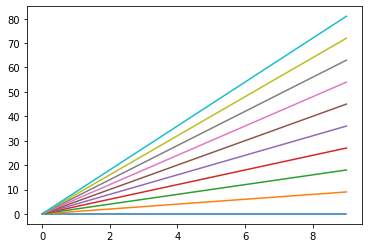

In [109]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

x = np.arange(10)
for i in range(len(colors)):
    y = i*np.arange(10)
    plt.plot(x, y, color=colors[i])